In [107]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm #library to make a progress bar when doing long for loops
from scipy.optimize import curve_fit #for forcing curve fit
import time #for testing efficiency of code

import warnings
warnings.filterwarnings('ignore') #suppressed normal warnings (disable this if something stops working)

xy = 'x' #we looking at x or y?

In [108]:
def process(filename): #return a processed dataframe
    data = pd.read_excel(filename, 
                    names = ["globaltime","dt",'rb1x','rb1y','rb1z','rb2x','rb2y','rb2z',
                            'rb3x','rb3y','rb3z','rb4x','rb4y','rb4z','rb5x','rb5y','rb5z',
                            'rb6x','rb6y','rb6z','rb7x','rb7y','rb7z','rb8x','rb8y','rb8z',
                            'xd','yd','thetad'])

    while data.iloc[0]['rb1z']==0.0:
        data = data.drop(0)
        data.index-=1
        
    #calculate robot position at each point

    #calculate the center of the robot
    Adet = (data['rb1x']*(data['rb4y']-data['rb6y']) -
           data['rb1y']*(data['rb4x']-data['rb6x']) +
           data['rb4x']*data['rb6y']-data['rb6x']*data['rb4y'])

    Bdet = ((data['rb1x']**2+data['rb1y']**2)*(data['rb6y']-data['rb4y'])  +
           (data['rb4x']**2+data['rb4y']**2)*(data['rb1y']-data['rb6y'])  +
           (data['rb6x']**2+data['rb6y']**2)*(data['rb4y']-data['rb1y']) )

    Cdet = ((data['rb1x']**2+data['rb1y']**2)*(data['rb4x']-data['rb6x'])  +
           (data['rb4x']**2+data['rb4y']**2)*(data['rb6x']-data['rb1x'])  +
           (data['rb6x']**2+data['rb6y']**2)*(data['rb1x']-data['rb4x']) )

    x_r = -Bdet/(2.*Adet)/1000.+Bdet[0]/(2.*Adet[0])/1000. #robot global position x in meters (adjusted to origin)
    y_r = -Cdet/(2.*Adet)/1000.+Cdet[0]/(2.*Adet[0])/1000. #robot global position y in meters

    x_mid = (data['rb1x']+data['rb8x'])/2./1000.+Bdet[0]/(2.*Adet[0])/1000. #calculate the midpoint of wheel 1 (adjusted to origin)
    y_mid = (data['rb1y']+data['rb8y'])/2./1000.+Cdet[0]/(2.*Adet[0])/1000.

    #rotate desired position to be in line with robot
    xd_rot = data['xd']
    yd_rot = data['yd']


    xr_rot =x_r*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))+y_r*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
    yr_rot =y_r*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))-x_r*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
    theta_r = np.arctan2(y_mid-y_r,x_mid-x_r) - np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]) #robot angle starting at 0
    
    pdata = pd.DataFrame()
    pdata.insert(0,"globaltime", data['globaltime'],True) #get global time
    pdata.insert(1, "x_r", xr_rot,True) #get robot positions (adjusted to origin)
    pdata.insert(2, "y_r", yr_rot,True)
    pdata.insert(3, "theta_r", theta_r,True)

    pdata.insert(4, "x_d", xd_rot,True) #get robot desired positions (adjusted for starting orientation)
    pdata.insert(5, "y_d", yd_rot,True)
    pdata.insert(6, "theta_d", data['thetad'],True)

    pdata.insert(7,'e_x', pdata['x_r']-pdata['x_d']) #calculate the errors at each point
    pdata.insert(8,'e_y', pdata['y_r']-pdata['y_d'])
    pdata.insert(9,'e_theta', pdata['theta_r']-pdata['theta_d'])
    
    return pdata


def get_points(df, points): #returns array of points
    
    smalldf = pd.DataFrame()
    
    for i in points:
        df_sort = df.iloc[(df['globaltime']-i).abs().argsort()[:2]].index.tolist() #get higher and lower value
        
        smalldf = smalldf.append(df.iloc[df_sort[0],:])
    
    smalldf.reset_index(inplace=True, drop=True)
    return smalldf
    

In [109]:
my_index = pd.MultiIndex(levels=[[]]*2,
                             labels=[[]]*2,
                             names=[u'trial',u'index'])
my_columns = [u'e_theta', u'e_x', u'e_y',u'globaltime',u'x_r',u'y_r',u'theta_r',u'x_d',u'y_d',u'theta_d']
multiframe=pd.DataFrame(index=my_index, columns=my_columns)

pull_points=[2,10,18,26,34,42,50,58,66,74,82,90,98,106,114]

for i in tqdm(range(10):
    frame = process("./31-08-2020/SMC_"+xy+"_zigzag"+str(i)+".xlsx")
    frame = get_points(frame, pull_points)
    multiframe = multiframe.append(frame.assign(k='trial'+str(i)).set_index('k',append=True).swaplevel(0,1))

#my_index.append(b.assign(k='C').set_index('k',append=True).swaplevel(0,1))

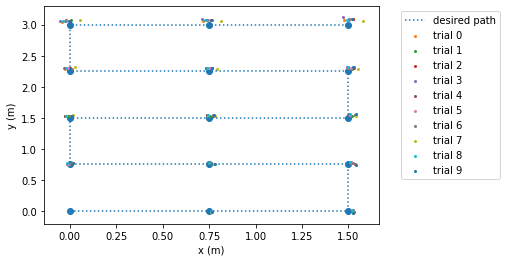

In [104]:
ax = plt.subplot(1,1,1)
ax.plot(multiframe.loc['trial0']['x_d'], multiframe.loc['trial0']['y_d'],':', label='desired path')
ax.scatter(multiframe.loc['trial0']['x_d'],multiframe.loc['trial0']['y_d'])
for i in range(10):
    ax.scatter(multiframe.loc['trial'+str(i)]['x_r'], multiframe.loc['trial'+str(i)]['y_r'],s=4, label='trial '+str(i))
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

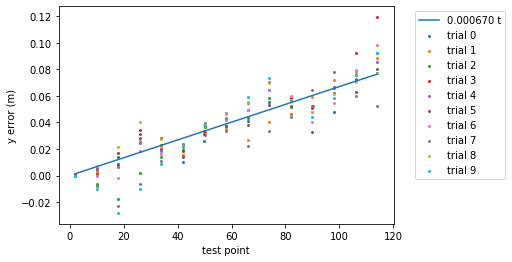

Drift = [0.02547089]m/m


In [105]:
def fit_func(x, a): #Come up with linear fits for drift (b=0)
    return a*x
m=0
for i in range(10):
    m = m+curve_fit(fit_func, multiframe.loc['trial'+str(i)]['globaltime'], multiframe.loc['trial'+str(i)]['e_'+xy])[0]/10.

ax = plt.subplot(1,1,1)
for i in range(10):
    ax.scatter(multiframe.loc['trial'+str(i)]['globaltime'],multiframe.loc['trial'+str(i)]['e_'+xy], s=4, label='trial '+str(i))
ax.plot(multiframe.loc['trial'+str(i)]['globaltime'],m*multiframe.loc['trial'+str(i)]['globaltime'],label=("%f t" % (m)))
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('test point')
plt.ylabel(xy +' error (m)')
plt.show()   

print("Drift = " + str(m*114./3.) + "m/m")

In [106]:
RMSE = 0

for i in range(10):
    RMSE = multiframe.loc['trial'+str(i)]['e_'+xy]**2

RMSE = np.sqrt(RMSE/10)
print(RMSE)

index
0     0.000002
1     0.003252
2     0.008891
3     0.003079
4     0.002835
5     0.006811
6     0.011872
7     0.013682
8     0.018755
9     0.023255
10    0.017854
11    0.014042
12    0.018423
13    0.023915
14    0.029164
Name: e_y, dtype: float64


e_theta       e_x       e_y  globaltime  theta_d   theta_r  \
trial  index                                                                
trial0 0     -0.000064 -0.000009  0.000074    1.992480      0.0 -0.000064   
       1      0.009956  0.011198  0.004547    9.993892      0.0  0.009956   
       2      0.019776  0.023068  0.014217   17.992609      0.0  0.019776   
       3      0.019330  0.015395  0.031308   25.992823      0.0  0.019330   
       4      0.026314  0.006083  0.022837   33.992779      0.0  0.026314   
...                ...       ...       ...         ...      ...       ...   
trial9 10     0.022523  0.015184  0.056459   81.996292      0.0  0.022523   
       11     0.014708  0.003539  0.044404   89.996697      0.0  0.014708   
       12     0.008423 -0.003880  0.058259   97.996091      0.0  0.008423   
       13     0.025073  0.008112  0.075626  105.996431      0.0  0.025073   
       14     0.038773  0.020231  0.092226  113.996215      0.0  0.038773   

               x_d       x_r   y_d       y_r  
trial  index                                  
trial0 0      0.00 -0.000009  0.00  0.000074  
       1      0.75  0.761198  0.00  0.004547  
       2      1.50  1.523068  0.00  0.014217  
       3      1.50  1.515395  0.75  0.781308  
       4      0.75  0.756083  0.75  0.772837  
...            ...       ...   ...       ...  
trial9 10     0.75  0.765184  2.25  2.306459  
       11     0.00  0.003539  2.25  2.294404  
       12     0.00 -0.003880  3.00  3.058259  
       13     0.75  0.758112  3.00  3.075626  
       14     1.50  1.520231  3.00  3.092226  

[150 rows x 10 columns]

In [54]:
RMSE_x = np.sqrt(sum(pdata['e_x']**2)/len(pdata['e_x']))
RMSE_y = np.sqrt(sum(pdata['e_y']**2)/len(pdata['e_y']))
RMSE_theta = np.sqrt(sum(pdata['e_theta']**2)/len(pdata['e_theta']))

RMSE_x_nt = np.sqrt(sum(pdata['e_x_nt']**2)/len(pdata['e_x']))
RMSE_y_nt = np.sqrt(sum(pdata['e_y_nt']**2)/len(pdata['e_y']))
RMSE_theta_nt = np.sqrt(sum(pdata['e_theta_nt']**2)/len(pdata['e_theta']))

In [10]:
print(RMSE_x)
print(RMSE_y)
print(RMSE_theta)

print(RMSE_x_nt)
print(RMSE_y_nt)
print(RMSE_theta_nt)

0.17287393243863944
0.2579143051273882
4.064514864590051
0.4377684780387974
0.5406187023096461
4.01094996569265


In [33]:
def fit_func(x, a): #Come up with linear fits for drift (b=0)
    return a*x

m_x = curve_fit(fit_func, pdata['globaltime'], pdata['e_x_nt'])[0]
m_y = curve_fit(fit_func, pdata['globaltime'], pdata['e_y_nt'])[0]
m_theta = curve_fit(fit_func, pdata['globaltime'], pdata['e_theta_nt'])[0]

plt.plot(pdata['globaltime'],m_x*pdata['globaltime'],label=("%f t" % (m_x)))
plt.plot(pdata['globaltime'],pdata['e_x_nt'])
plt.legend()
plt.show()

plt.plot(pdata['globaltime'],m_y*pdata['globaltime'],label=("%f t" % (m_y)))
plt.plot(pdata['globaltime'],pdata['e_y_nt'])
plt.legend()
plt.show()

plt.plot(pdata['globaltime'],m_theta*pdata['globaltime'],label=("%f t" % (m_theta)))
plt.plot(pdata['globaltime'],pdata['e_theta_nt'])
plt.legend()
plt.show()

'''

m_x,b_x = np.polyfit(pdata['globaltime'], pdata['e_x_nt'], 1) # Come up with linear fits for drift (b!=0)
m_y,b_y = np.polyfit(pdata['globaltime'], pdata['e_y_nt'], 1)
m_theta,b_theta = np.polyfit(pdata['globaltime'], pdata['e_theta_nt'], 1)

plt.plot(pdata['globaltime'],m_x*pdata['globaltime']+b_x,label=("%f t %f" % (m_x,b_x)))
plt.plot(pdata['globaltime'],pdata['e_x_nt'])
plt.legend()
plt.show()

plt.plot(pdata['globaltime'],m_y*pdata['globaltime']+b_y,label=("%f t %f" % (m_y,b_y)))
plt.plot(pdata['globaltime'],pdata['e_y_nt'])
plt.legend()
plt.show()

plt.plot(pdata['globaltime'],m_theta*pdata['globaltime']+b_theta,label=("%f t %f" % (m_theta,b_theta)))
plt.plot(pdata['globaltime'],pdata['e_theta_nt'])
plt.legend()
plt.show()'''

ValueError: array must not contain infs or NaNs

In [40]:
pdata.insert(13,'e_x_adj',pdata['e_x_nt']-m_x*pdata['globaltime']) #calculate adjusted errors (b=0)
pdata.insert(14,'e_y_adj',pdata['e_y_nt']-m_y*pdata['globaltime'])
pdata.insert(15,'e_theta_adj',pdata['e_theta_nt']-m_theta*pdata['globaltime'])

'''

pdata.insert(13,'e_x_adj',pdata['e_x_nt']-m_x*pdata['globaltime']-b_x) #calculate adjusted errors (b!=0)
pdata.insert(14,'e_y_adj',pdata['e_y_nt']-m_y*pdata['globaltime']-b_y)
pdata.insert(15,'e_theta_adj',pdata['e_theta_nt']-m_theta*pdata['globaltime']-b_theta)'''

"\n\npdata.insert(13,'e_x_adj',pdata['e_x_nt']-m_x*pdata['globaltime']-b_x) #calculate adjusted errors (b!=0)\npdata.insert(14,'e_y_adj',pdata['e_y_nt']-m_y*pdata['globaltime']-b_y)\npdata.insert(15,'e_theta_adj',pdata['e_theta_nt']-m_theta*pdata['globaltime']-b_theta)"

In [41]:
RMSE_x_adj=np.sqrt(sum(pdata['e_x_adj']**2)/len(pdata['e_x']))
RMSE_y_adj=np.sqrt(sum(pdata['e_y_adj']**2)/len(pdata['e_x']))
RMSE_theta_adj=np.sqrt(sum(pdata['e_theta_adj']**2)/len(pdata['e_x']))

print(RMSE_x_adj)
print(RMSE_y_adj)
print(RMSE_theta_adj)

0.8118218536330315
0.9774432625632172
2.410022590821611


In [32]:
pdata['e_x_nt']=pdata['e_x']
pdata['e_y_nt']=pdata['e_y']
pdata['e_theta_nt']=pdata['e_theta']

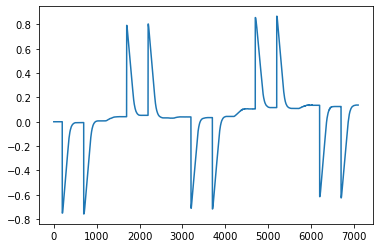

In [34]:
plt.plot(pdata['e_x'])

     0  1
A d  1  2
  e  3  4
B d  5  6
  e  7  8
